In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

# トレンドモデル
## データ生成
- 解析対象のトレンドモデルを作る

In [2]:
num_step = 100
step_size = 0.1

In [3]:
np.random.seed(1)

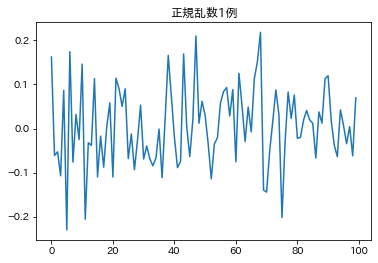

In [4]:
z = np.random.randn(num_step) * step_size

plt.figure()
plt.plot(z)
plt.title("正規乱数1例");

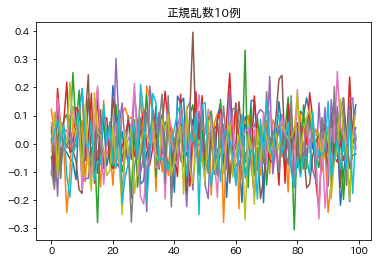

In [5]:
zz = np.random.randn(num_step,10) * step_size

plt.figure()
plt.plot(zz)
plt.title("正規乱数10例");

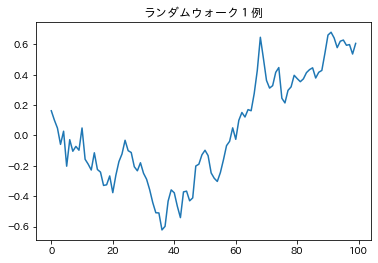

In [6]:
b = np.cumsum(z)

plt.figure()
plt.plot(b)
plt.title("ランダムウォーク１例");

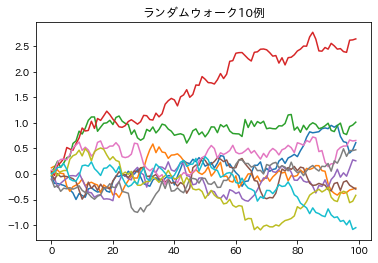

In [7]:
bb = np.cumsum(zz, axis=0)

plt.figure()
plt.plot(bb)
plt.title("ランダムウォーク10例");

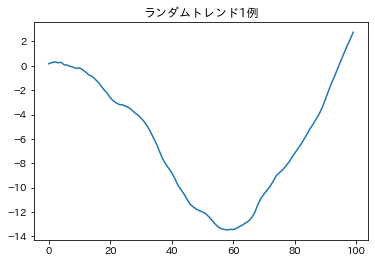

In [8]:
u = np.cumsum(b)

plt.figure()
plt.plot(u)
plt.title("ランダムトレンド1例");

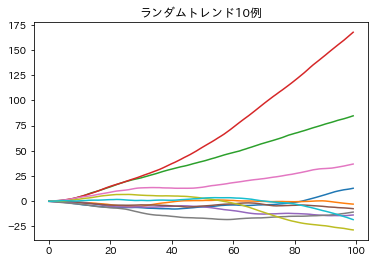

In [9]:
uu = np.cumsum(bb, axis=0)

plt.figure()
plt.plot(uu)
plt.title("ランダムトレンド10例");

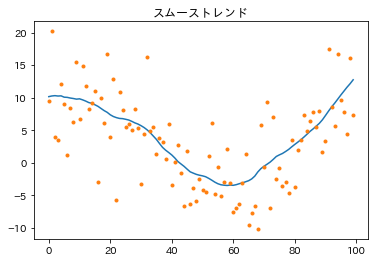

In [10]:
sigma = 5
c = 10
e = np.random.randn(num_step)

u = u + c
y = u + e * sigma

plt.figure()
plt.plot(u)
plt.plot(y, '.')
plt.title("スムーストレンド");

- ランダムウォーク:乱数の累積和でできる系列データ
- ランダムトレンド:ランダムウォークの累積和でできる系列データ
- トレンドモデルに観測ノイズが混ざったのがスムースモデル

## 推論

In [11]:
import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as jnp

import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(5)#一回推論した後に数字変える場合はカーネルリスタートする

In [23]:
t = np.arange(len(y))
y = jnp.array(y)

### モデリング
- ランダムウォーク
    - $\xi_n\sim\mathcal{N}(\xi_n|0, \sigma_{\xi})$
    - $\beta_{n}=\beta_{n-1}+\xi_{n}$
- ランダムトレンド
    - $\mu_{n} = \mu_{n-1}+\beta_n$
- スムーストレンド
    - $\epsilon_n \sim \mathcal{N}(\epsilon_n|0, \sigma_{\epsilon})$※観測ノイズ
    - $y_n = \mu_n + \epsilon_n$

In [26]:
def model(y_obs):
    num_steps = len(y_obs)
    
    # ランダムウォーク変数の分散パラの事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))
    # ランダムウォーク変数の事前分布
    b = numpyro.sample("b", dist.GaussianRandomWalk(scale=sd_b, num_steps=num_steps))

    #トレンドモデルの初期値（バイアス）の事前分布
    c = numpyro.sample("c", dist.Normal(10))

    # ランダムトレンド（確率変数ではない）
    u = numpyro.deterministic("u", jnp.cumsum(b) + c)
    
    #観測ノイズの分散パラの事前分布
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    
    #観測モデル（スムーストレンド）
    numpyro.sample("y", dist.Normal(u, sd_y), obs=y_obs)

In [15]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

mcmc.run(jax.random.PRNGKey(1), y)

trace = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
idata = az.from_numpyro(mcmc)

In [17]:
az.summary(idata, var_names=["c", "sd_b", "sd_y"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,9.854,0.835,8.246,11.369,0.012,0.008,5227.0,3984.0,1.00
sd_b,0.099,0.040,0.044,0.177,0.004,0.003,106.0,130.0,1.03
sd_y,4.874,0.358,4.212,5.545,0.004,0.003,6894.0,3854.0,1.00


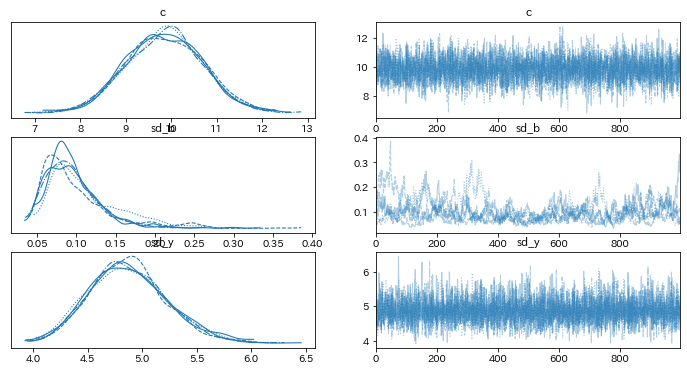

In [18]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

In [19]:
u_samled = trace["u"]

In [20]:
mu = jnp.mean(u_samled, 0)
pi = jnp.percentile(u_samled, np.array([5, 95]), 0)

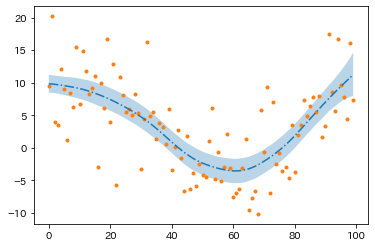

In [21]:
plt.plot(t, y, ".", color="C1")

plt.plot(t, mu, "-.")
plt.fill_between(t, pi[0, :], pi[1, :], alpha=0.3);